## Carga de Datos

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('dbProcessed.csv')
df['date'] = pd.to_datetime(df['date'])
df

,date,tweet,relevance,topic,Palabras,procTweet,Rating,Sentimiento
0,2023-01-01,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...,5,1.0
1,2023-01-02,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm,5,1.0
2,2023-01-02,Muchas gracias!,0,misc,2,muchas gracias,5,1.0
3,2023-01-02,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...,1,0.0
4,2023-01-02,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...,1,0.0
...,...,...,...,...,...,...,...,...
806,2024-04-21,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado,5,1.0
807,2024-04-23,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias,5,1.0
808,2024-04-23,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...,5,1.0
809,2024-04-25,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...,1,0.0


## Modelo para Predecir Sentimientos

In [10]:
dfSent = df[['procTweet', 'Sentimiento']]
dfSent = dfSent.rename(columns={"procTweet": "Text", "Sentimiento": "Sentimiento"})
dfSent

,Text,Sentimiento
0,resuelto muchísimas gracias excelente servic...,1.0
1,muchas gracias espero dm,1.0
2,muchas gracias,1.0
3,similar paso quería renovar token poder hacer...,0.0
4,yeeeei través cuenta acabo contratar cuenta a...,0.0
...,...,...
806,ahora confirmo gracias estimado,1.0
807,cara_desanimada acuerdo muchas gracias,1.0
808,tío van graduar tdc garantizada hace año saqu...,1.0
809,duda quién ver si problemas aumentar línea cr...,0.0


In [23]:
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))

import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, dfSent.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', dfSent.iloc[i]['Text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [25]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = dfSent['Sentimiento'].values

In [66]:
from joblib import dump
dump(cv, 'vectorizer.joblib') 

['vectorizer.joblib']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (648, 2081)
y train: (648,)
X test: (163, 2081)
y test: (163,)


### Oversampling

In [28]:
from imblearn.over_sampling import RandomOverSampler
over_ada = RandomOverSampler(random_state=42)
X_train, y_train = over_ada.fit_resample(X_train, y_train)


print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (932, 2081)
y train: (932,)
X test: (163, 2081)
y test: (163,)


### Escalamiento

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [65]:
from joblib import dump
dump(scaler, 'scaler.joblib') 

['scaler.joblib']

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier(random_state = 31)
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier(random_state=31)

In [48]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.7361963190184049


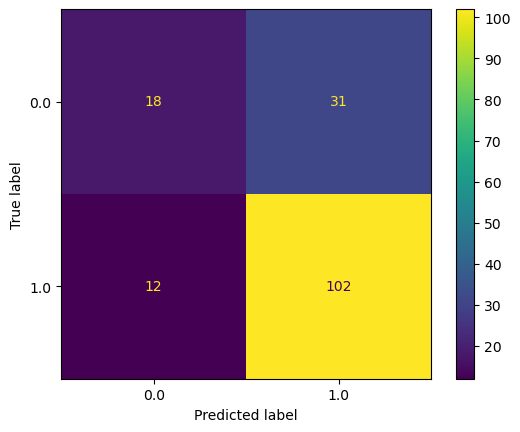

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [50]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9132807137954702
Standard Variance : 0.057003532828453544


In [51]:
from joblib import dump
dump(model_rf, 'modelSentiment.joblib') 

['modelSentiment.joblib']

### Grid Search

In [40]:
params = {
    'bootstrap': [True, False],
    'max_depth': [80, 100, 200],
    'min_samples_split': [8, 2, 50, 25, 4],
    'n_estimators': [100, 300, 50]
}

In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=31),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [80, 100, 200],
                         'min_samples_split': [8, 2, 50, 25, 4],
                         'n_estimators': [100, 300, 50]},
             return_train_score=True)

In [42]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': False, 'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 300}


In [43]:
from sklearn.metrics import accuracy_score
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 98.49308536003817
Cross validation mean accuracy on test set : 85.68669527896996
Accuracy score for test set : 0.7361963190184049


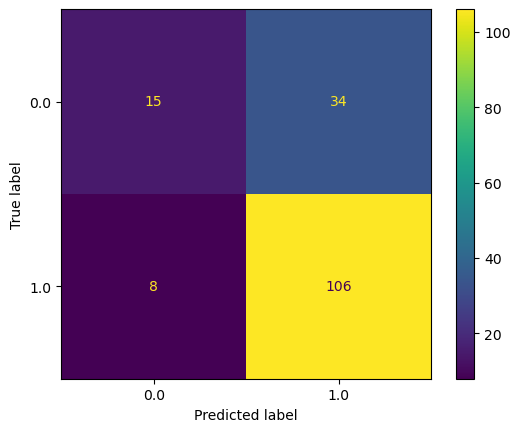

In [46]:
rfc_model_op = grid_search.best_estimator_

#Predicting on the test set
y_preds = rfc_model_op.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

## Modelo para Predecir Relevancia

In [54]:
dfRel = df[['procTweet', 'relevance']]
dfRel = dfRel.rename(columns={"procTweet": "Text", "relevance": "relevance"})
dfRel

,Text,relevance
0,resuelto muchísimas gracias excelente servic...,1
1,muchas gracias espero dm,0
2,muchas gracias,0
3,similar paso quería renovar token poder hacer...,1
4,yeeeei través cuenta acabo contratar cuenta a...,1
...,...,...
806,ahora confirmo gracias estimado,0
807,cara_desanimada acuerdo muchas gracias,0
808,tío van graduar tdc garantizada hace año saqu...,1
809,duda quién ver si problemas aumentar línea cr...,1


In [56]:
y = dfRel['relevance'].values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (648, 2081)
y train: (648,)
X test: (163, 2081)
y test: (163,)


In [58]:
from imblearn.over_sampling import RandomOverSampler
over_ada = RandomOverSampler(random_state=42)
X_train, y_train = over_ada.fit_resample(X_train, y_train)


print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (868, 2081)
y train: (868,)
X test: (163, 2081)
y test: (163,)


In [59]:
X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
#Fitting scaled X_train and y_train on Random Forest Classifier
modelRel = RandomForestClassifier(random_state = 31)
modelRel.fit(X_train_scl, y_train)

RandomForestClassifier(random_state=31)

In [61]:
print("Training Accuracy :", modelRel.score(X_train_scl, y_train))
print("Testing Accuracy :", modelRel.score(X_test_scl, y_test))

Training Accuracy : 0.9988479262672811
Testing Accuracy : 0.7852760736196319


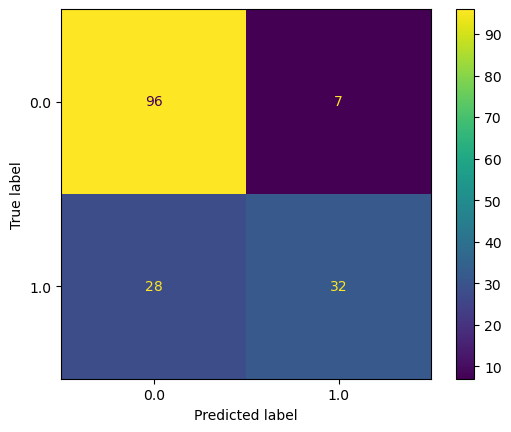

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Predicting on the test set
y_preds = modelRel.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [63]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = modelRel, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9159582999198076
Standard Variance : 0.0444602257599238


In [64]:
from joblib import dump
dump(modelRel, 'modelRel.joblib') 

['modelRel.joblib']

## Modelo para Predecir Topic

In [67]:
dfTopic = df[['procTweet', 'topic']]
dfTopic = dfTopic.rename(columns={"procTweet": "Text", "topic": "topic"})
dfTopic

,Text,topic
0,resuelto muchísimas gracias excelente servic...,misc
1,muchas gracias espero dm,misc
2,muchas gracias,misc
3,similar paso quería renovar token poder hacer...,misc
4,yeeeei través cuenta acabo contratar cuenta a...,misc
...,...,...
806,ahora confirmo gracias estimado,misc
807,cara_desanimada acuerdo muchas gracias,misc
808,tío van graduar tdc garantizada hace año saqu...,support
809,duda quién ver si problemas aumentar línea cr...,support


In [68]:
y = dfTopic['topic'].values

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (648, 2081)
y train: (648,)
X test: (163, 2081)
y test: (163,)


In [70]:
from imblearn.over_sampling import RandomOverSampler
over_ada = RandomOverSampler(random_state=42)
X_train, y_train = over_ada.fit_resample(X_train, y_train)


print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (1194, 2081)
y train: (1194,)
X test: (163, 2081)
y test: (163,)


In [71]:
X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

In [72]:
from sklearn.ensemble import RandomForestClassifier
#Fitting scaled X_train and y_train on Random Forest Classifier
modelTopic = RandomForestClassifier(random_state = 31)
modelTopic.fit(X_train_scl, y_train)

RandomForestClassifier(random_state=31)

In [73]:
print("Training Accuracy :", modelTopic.score(X_train_scl, y_train))
print("Testing Accuracy :", modelTopic.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.901840490797546


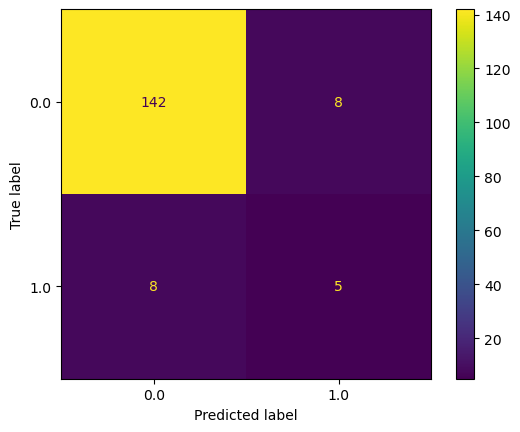

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Predicting on the test set
y_preds = modelTopic.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [76]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = modelTopic, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9882843137254902
Standard Variance : 0.007646985075726125


In [77]:
from joblib import dump
dump(modelTopic, 'modelTopic.joblib') 

['modelTopic.joblib']